# Replicating the use of ViT for near out-of-distributution detection from
# **Exploring the Limits of Out-of-Distribution Detection**
by Stanislav Fort, Jie Ren, Balaji Lakshminarayanan

This is Colab performs a key experiments from [Exploring the Limits of Out-of-Distribution Detection](https://arxiv.org/abs/2106.03004), [accepted at NeurIPS 2021](https://proceedings.neurips.cc/paper/2021/hash/3941c4358616274ac2436eacf67fae05-Abstract.html). It uses a large, pretrained and finetuned [Vision Transformer](https://arxiv.org/abs/2010.11929), extracts its embeddings, and performs OOD detection on the hard near-OOD [CIFAR-100 vs CIFAR-10 task](https://paperswithcode.com/sota/out-of-distribution-detection-on-cifar-100-vs).

This Colab is heavily inspired by the the Google [Colab on using their pretrained and finetuned transformers](https://github.com/google-research/vision_transformer). We modified the `models.py` and load it from our own [repository](https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection) to allow for the extraction of image embeddings from the penultimate layer of the ViT that we use for OOD detection.

You should expect to run this Colab from top to bottom in around 20 minutes on a single free Colab GPU. It is by default extracting embeddings only for 1/10 of the train and test sets of CIFAR-10 and CIFAR-100 to speed things up. If you want to change that, just set `N_test = 10000` and `N_train = 50000`.

You should expect to see the following plots:

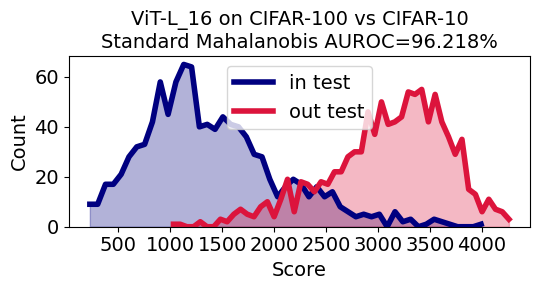

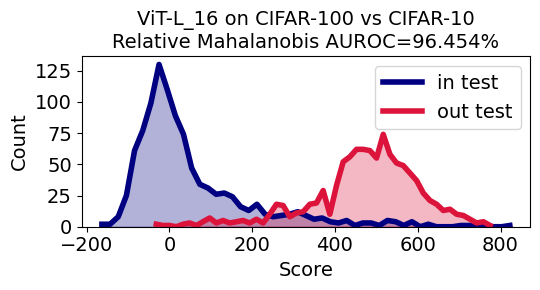

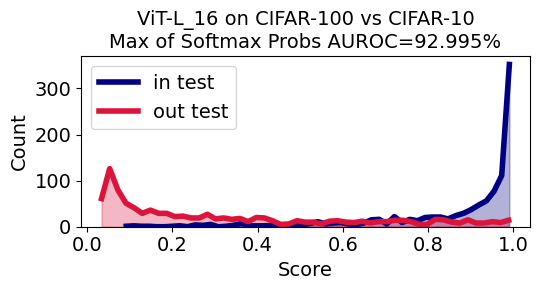

# Imports and loading

In [ ]:
import numpy as np

In [ ]:
![ -d vision_transformer ]
!pwd

/content


In [ ]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 6), reused 20 (delta 4), pack-reused 0
Receiving objects: 100% (49/49), 1.86 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.2/777.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!ls vision_transformer/vit_jax/

checkpoint.py		__init__.py	   models.py	     preprocess_test.py    train_test.py
checkpoint_test.py	input_pipeline.py  models_resnet.py  requirements-tpu.txt  utils.py
configs			main.py		   models_test.py    requirements.txt
inference_time.py	models_lit.py	   models_vit.py     test_utils.py
inference_time_test.py	models_mixer.py    preprocess.py     train.py


In [ ]:
# fetch out repository to get the modified models.py file with the pre-logits extraction
!git clone --depth=1 https://github.com/stanislavfort/exploring_the_limits_of_OOD_detection

Cloning into 'exploring_the_limits_of_OOD_detection'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 338.19 KiB | 3.64 MiB/s, done.


In [ ]:
!rm vision_transformer/vit_jax/models.py
!cp exploring_the_limits_of_OOD_detection/models.py vision_transformer/vit_jax/

In [ ]:
!pip install einops
!pip install clu

  Using cached einops-0.7.0-py3-none-any.whl (44 kB)
  Using cached clu-0.0.10-py3-none-any.whl (100 kB)
  Using cached ml_collections-0.1.1.tar.gz (77 kB)
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.23.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=f889551e47ebd190b93661065c30fbd3234c90135b2ef1f19ea71c57fafe9046
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 require

In [ ]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/numpy/matrixlib/__init__.py", line 6, in <module>
    __all__ = defmatrix.__all__
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.lib failed: Traceback (most recent 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of numpy failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.10/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/numpy/__init__.py", line 191, in <module>
    core.numerictypes.typeDict,
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/__init__.py", line 161, in __getattr__
    raise AttributeEr

ModuleNotFoundError: ignored

In [ ]:
#to add the prelogits versions
from google.colab import files

files.view('vision_transformer/vit_jax/models.py')

In [ ]:
!nvidia-smi

Tue Oct 17 16:35:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt


# Loading ViT checkpoints from Google Brain repo

### Load a checkpoint

In [ ]:
#selecting a ViT checkpoint
filename = 'L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.01-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

In [ ]:
ds, ds_info = tfds.load(tfds_name, with_info=True,batch_size=128)
ds_info

In [ ]:
# Removed model_name
# ---------------------------------------------------------------------------

'''
TypeError                                 Traceback (most recent call last)

<ipython-input-19-644b9a7885a3> in <cell line: 2>()
      1 # Get a clean model
----> 2 model = models.VisionTransformer(num_classes=ds_info.features['label'].num_classes, **model_config)

TypeError: VisionTransformer.__init__() got an unexpected keyword argument 'model_name'
'''

In [ ]:
model_config.unlock()
del model_config.model_name
model_config.lock()

In [ ]:
# Get a clean model
model = models.VisionTransformer(num_classes=ds_info.features['label'].num_classes, **model_config)

In [ ]:
# Load a checkpoint from cloud
# takes a while for a big model
params = checkpoint.load(path)

In [ ]:
# our modified model that outputs pre-logits = embeddings for OOD detection
model_prelogits = models.VisionTransformer_prelogits(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [ ]:
model_prelogits.save_pretrained("my_model")

# Getting unaugmented datasets

In [ ]:
def pp(img, sz):
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])

  return img

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

def prepare_pure_dataset(ds_in, num_classes,repeats = 1,shuffle=True, batch_size=128):

  ds_in = ds_in.map(lambda d: {"image": pp(d["image"],resolution), "label": d["label"]}, tf.data.experimental.AUTOTUNE)

  ds_in = ds_in.repeat(repeats)
  if shuffle:
    ds_in = ds_in.shuffle(200000)

  ds_in = ds_in.batch(batch_size, drop_remainder=True)

  return ds_in

In [ ]:
batch_size = 128

cifar10_ds_train = prepare_pure_dataset(tfds.load('cifar10', split='train', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar10_ds_test = prepare_pure_dataset(tfds.load('cifar10', split='test', shuffle_files=False), 10, shuffle=False, batch_size=batch_size)
cifar100_ds_train = prepare_pure_dataset(tfds.load('cifar100', split='train', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)
cifar100_ds_test = prepare_pure_dataset(tfds.load('cifar100', split='test', shuffle_files=False), 100, shuffle=False, batch_size=batch_size)

NameError: ignored

In [ ]:
print(cifar10_ds_train.shape, cifar10_ds_test.shape)
print(cifar100_ds_train.shape, cifar100_ds_test.shape)

NameError: ignored

In [ ]:
#verification
def get_value_spreads_for_dataset(ds_in):
  batch = next(ds_in.as_numpy_iterator())
  # print(batch.shape)
  images = batch["image"]
  min_now,mean_now,max_now = np.min(images),np.mean(images),np.max(images)
  return min_now,mean_now,max_now

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar10_ds_test)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_train)
print(min_now,mean_now,max_now)

min_now,mean_now,max_now = get_value_spreads_for_dataset(cifar100_ds_test)
print(min_now,mean_now,max_now)


0.0 0.47670496 1.0
0.0 0.4786665 1.0
0.0 0.5022136 1.0
0.0 0.47278368 1.0


# Prelogits (embedings) extraction

## Extractor

In [ ]:
import time

def standalone_get_prelogits(params, ds_in,image_count=50000):
  """Returns prelogits on the dataset"""
  prelogits_all = []
  logits_all = []
  labels_all = []

  ts = []

  t1 = time.time()

  for batch in ds_in.as_numpy_iterator():

    prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)
    logits = model.apply({'params': params}, batch["image"], train=False)

    prelogits_all.append(prelogits)
    logits_all.append(logits)
    labels_all.append(batch["label"])

    count_so_far = len(np.concatenate(prelogits_all,axis=0))

    t2 = time.time()
    ts.append(t2-t1)
    t1 = time.time()

    t_rem = (image_count-count_so_far)*np.mean(ts)/batch_size

    print("Images done="+str(count_so_far)+" time remaining="+str(int(t_rem))+"s")

    if count_so_far >= image_count:
      break #early break for subsets of data

  return np.concatenate(prelogits_all,axis=0), np.concatenate(logits_all,axis=0), np.concatenate(labels_all,axis=0)

## Getting the prelogits

The full datasets extraction will take some time. Taking a 1/10 subset is sufficient to show the effectivness of the Mahalanobis distance and Relative Mahalanobis distance as compared to the Maximum over Softmax Probabilities and runs in 20 mins on a single V100 GPU in a Colab (probably slower on a P100).

In [ ]:
# choosing the subsets of the train and test set to extract embeddings for
N_train = 5000
N_test = 1000

assert N_train <= 50000
assert N_test <= 10000

### CIFAR-10 test (1.5 minutes)

In [ ]:
cifar10_test_prelogits, cifar10_test_logits, cifar10_test_labels = standalone_get_prelogits(
    params,
    cifar10_ds_test,
    image_count=N_test
    )

### CIFAR-100 test (1.5 minutes)

In [ ]:
cifar100_test_prelogits, cifar100_test_logits, cifar100_test_labels = standalone_get_prelogits(
    params,
    cifar100_ds_test,
    image_count=N_test
    )

### CIFAR-10 train (8 minutes)

In [ ]:
cifar10_train_prelogits, cifar10_train_logits, cifar10_train_labels = standalone_get_prelogits(
    params,
    cifar10_ds_train,
    image_count=N_train
    )

### CIFAR-100 train (8 minutes)

In [ ]:
cifar100_train_prelogits, cifar100_train_logits, cifar100_train_labels = standalone_get_prelogits(
    params,
    cifar100_ds_train,
    image_count=N_train
    )

## Accuracies {of Pre-Trained VIT (ImageNet)}

In [ ]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_logits,axis=-1) == cifar100_test_labels
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_logits,axis=-1) == cifar100_train_labels
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

# Computing near-OOD AUROC

In [ ]:
cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

# Save emebedings for future experiments
This will save computation and time

In [ ]:
def save_embeddings(file_prefix, embeds, preds, labels):
  np.save(file_prefix + 'embeds', embeds)
  np.save(file_prefix + 'preds', preds)
  np.save(file_prefix + 'labels', labels)

# cifar 100
save_embeddings('cifar10_train_', cifar10_train_embeds, cifar10_train_preds, cifar10_y_train)
save_embeddings('cifar10_test_', cifar10_test_embeds, cifar10_test_preds, cifar10_y_test)

save_embeddings('cifar100_train_', cifar100_train_embeds, cifar100_train_preds, cifar100_y_train)
save_embeddings('cifar100_test_', cifar100_test_embeds, cifar100_test_preds, cifar100_y_test)

In [ ]:
# LOAD
cifar10_test_embeds = np.load('cifar10_test_prelogits.npy')
cifar10_y_test = np.load('cifar10_test_labels.npy')
cifar10_test_preds = np.load('cifar10_test_logits.npy')

cifar100_test_embeds = np.load('cifar100_test_prelogits.npy')
cifar100_y_test = np.load('cifar100_test_labels.npy')
cifar100_test_preds = np.load('cifar100_test_logits.npy')

cifar10_train_embeds = np.load('cifar10_train_prelogits.npy')
cifar10_y_train = np.load('cifar10_train_labels.npy')
cifar10_train_preds = np.load('cifar10_train_logits.npy')

cifar100_train_embeds = np.load('cifar100_train_prelogits.npy')
cifar100_y_train = np.load('cifar100_train_labels.npy')
cifar100_train_preds = np.load('cifar100_train_logits.npy')


In [ ]:
# checking the accuracy on CIFAR-100

finetune_test_acc = np.mean(
    np.argmax(cifar100_test_preds,axis=-1) == cifar100_y_test
    )

print("CIFAR-100 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar100_train_preds,axis=-1) == cifar100_y_train
    )

print("CIFAR-100 train accuracy = "+str(finetune_train_acc))

CIFAR-100 test accuracy = 0.943359375
CIFAR-100 train accuracy = 0.9728515625


In [ ]:
# checking the accuracy on CIFAR-10
# The reason for low acc is, VIT is fine tune for C100 (Target model)
# hence cifar10_test_preds is incorrect labels (1-100) and cifar10_y_test is from (1- 10)

finetune_test_acc = np.mean(
    np.argmax(cifar10_test_preds,axis=-1) == cifar10_y_test
    )

print("CIFAR-10 test accuracy = "+str(finetune_test_acc))

finetune_train_acc = np.mean(
    np.argmax(cifar10_train_preds,axis=-1) == cifar10_y_train
    )

print("CIFAR-10 train accuracy = "+str(finetune_train_acc))

CIFAR-10 test accuracy = 0.0029296875
CIFAR-10 train accuracy = 0.0041015625


## Computing Mahalanobis means and covariances

In [ ]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

In [ ]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):

  # storing the replication results
  maha_intermediate_dict = dict()

  description = ""

  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict

In [ ]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1]
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0]

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

## Standard Mahalanobis distance

In [ ]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )


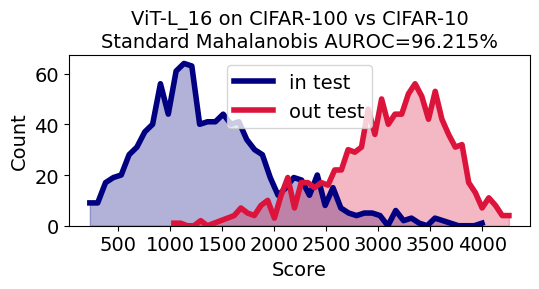

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots,
    scores,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

In [ ]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

outdist_test_embeds = cifar10_test_embeds

# Compute Maha_distance
indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

# Compute Maha_distance
outdist_dists = []
for c in range(100):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)



In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)


# Here One hot indicate:
#   0 = in_dist
#   1 = out_dist

# Score is the real value

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [ ]:
print("CIFAR-100 score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("CIFAR-10 score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

CIFAR-100 score = 1391.5466061942946+-649.738812528137
CIFAR-10 score = 3097.353335240513+-569.7668389689245


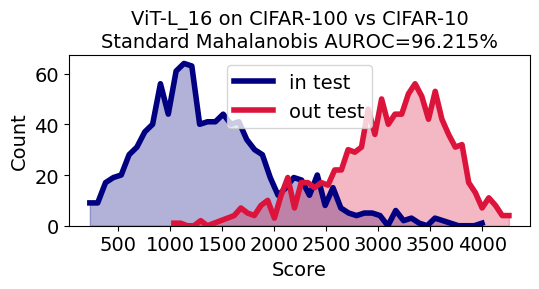

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots,
    scores,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

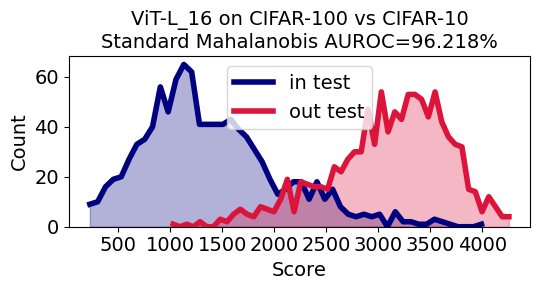

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots,
    scores,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

# Lets compute for Single sample

In [ ]:
# Compute the indist_min
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = cifar100_test_embeds

# np.save('class_means', class_means)
# np.save('class_cov_invs', class_cov_invs)
# np.save('indist_test_embeds', indist_test_embeds)

# test_sample = cifar10_test_embeds[:1]

# Compute Maha_distance
indist_dists = []
for c in range(100):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

# Compute Maha_distance
# outdist_dists = []
# for c in range(100):
#   outdist_offset_now = test_sample - class_means[c].reshape([1,-1])
#   maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
#   outdist_dists.append(maha_dists_now)

indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

# outdist_dists_byclass = np.stack(outdist_dists,axis=1)
# outdist_min = np.min(outdist_dists_byclass,axis=1)


# Here One hot indicate:
#   0 = in_dist
#   1 = out_dist

# Score is the real value

# onehots1 = np.array([1]*len(outdist_min) + [0]*len(indist_min))
# scores1 = np.concatenate([outdist_min,indist_min],axis=0)

## Inference function

In [ ]:
# Inference function

def is_indist_inference(sample, train_dist_class_means, train_dist_class_cov_invs, indist_min, num_class=100 ):
  # Compute Maha_distance
  outdist_dists = []
  for c in range(num_class):
    outdist_offset_now = sample - train_dist_class_means[c].reshape([1,-1])
    maha_dists_now = np.sum(np.matmul(outdist_offset_now,train_dist_class_cov_invs[c])*outdist_offset_now,axis=1)
    outdist_dists.append(maha_dists_now)

  outdist_dists_byclass = np.stack(outdist_dists,axis=1)
  outdist_min = np.min(outdist_dists_byclass,axis=1)

  out_score = np.squeeze(outdist_min, axis=0)
  std = np.std(indist_min)
  u = np.mean(indist_min)

  # Withing STD, in_dist else out_dist
  # -std ... mean(u)... std+
  if( out_score >= (u - std) OR out_score <= (u + std))
  return True if out_score >= (u - std) OR out_score <= (u + std) else False


In [ ]:
# choose a sample
# Note shape must be [1, 1024], (1024 is the embeding dimention from VIT)
test_sample = cifar10_test_embeds[:1]

# get embeding
prelogits = model_prelogits.apply({'params': params}, batch["image"], train=False)


sample_in = is_indist_inference(
    test_sample,
    class_means,
    class_cov_invs,
    indist_min,
    num_class=100
    )

if sample_in :
  print("Indistribution")
else:
  print("Out of distribution")

Out of distribution


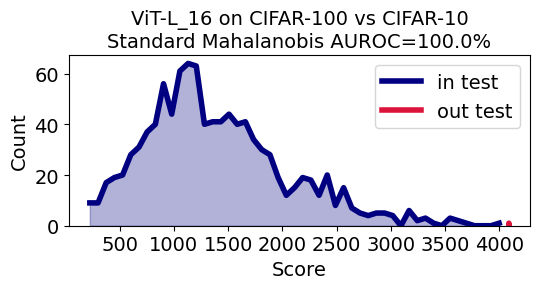

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots1,
    scores1,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nStandard Mahalanobis"
    )

In [ ]:
#(Optional)

## Relative Mahalanobis distance

In [ ]:
# Computer Original dataset(Cifar100) Mean & Covariance

train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [ ]:
# Now compute

onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(cifar100_train_embeds)[:,:],
        cifar100_y_train,
        np.array(cifar100_test_embeds)[:,:],
        np.array(cifar10_test_embeds)[:,:],
        indist_classes=100,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = True,
    )



In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [ ]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [ ]:
print("CIFAR-100 score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("CIFAR-10 score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

CIFAR-100 score = 53.70648706882346+-140.7992890457364
CIFAR-10 score = 479.0666854535716+-131.749445282126


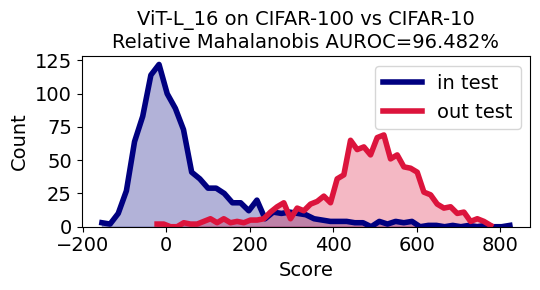

In [ ]:
auroc, to_replot_dict = get_auroc(
    onehots,
    scores,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nRelative Mahalanobis"
    )

## Max of Softmax Probabilities score

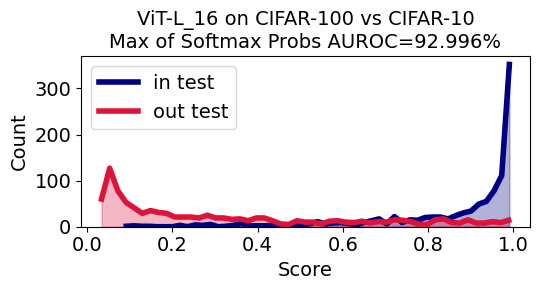

In [ ]:
scores = np.array(
    np.concatenate([
     np.max(np_softmax(cifar100_test_logits),axis=-1),
     np.max(np_softmax(cifar10_test_logits),axis=-1),
    ],axis=0)
)

onehots = np.array(
    [1]*len(cifar100_test_logits)+[0]*len(cifar10_test_logits)
)

auroc, to_replot_dict = get_auroc(
    onehots,
    scores,
    make_plot=True,
    add_to_title="ViT-L_16 on CIFAR-100 vs CIFAR-10\nMax of Softmax Probs",
    swap_classes=True,
    )

# Our Novel approch for OOD

In [ ]:
'''
cifar100_train_embeds = cifar100_train_prelogits
cifar100_y_train = cifar100_train_labels
cifar100_train_preds = cifar100_train_logits

cifar100_test_embeds = cifar100_test_prelogits
cifar100_y_test = cifar100_test_labels
cifar100_test_preds = cifar100_test_logits

cifar10_train_embeds = cifar10_train_prelogits
cifar10_y_train = cifar10_train_labels
cifar10_train_preds = cifar10_train_logits

cifar10_test_embeds = cifar10_test_prelogits
cifar10_y_test = cifar10_test_labels
cifar10_test_preds = cifar10_test_logits


'''

In [ ]:
x = np.concatenate([cifar100_train_embeds, cifar10_train_embeds],axis=0)
x.shape

(10240, 1024)

## Train OOD detector on both in(C100) and out(C10) data

In [ ]:
# PREPARE DATA

x_mix_train = np.concatenate([cifar100_train_embeds, cifar10_train_embeds],axis=0)
y_mix_train = np.array([1] * len(cifar100_y_train) + [0] * len(cifar10_y_train))


x_mix_test = np.concatenate([cifar100_test_embeds, cifar10_test_embeds],axis=0)
y_mix_test = np.array([1] * len(cifar100_y_test) + [0] * len(cifar10_y_test))

print("Train data embeds set : ", x_mix_train.shape)
print("Train labels embeds set : ", y_mix_train.shape)
print("Test data embeds set : ", x_mix_test.shape)
print("Test labels embeds set : ", y_mix_test.shape)


Train data embeds set :  (10240, 1024)
Train labels embeds set :  (10240,)
Test data embeds set :  (2048, 1024)
Test labels embeds set :  (2048,)


In [ ]:
# # SPLIT FOR TRAINING
# from sklearn.model_selection import train_test_split

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(x_mix_train, y_mix_train, test_size=0.33, random_state=42)

In [ ]:
# Train the SVM classifier on the training data
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:


svm = SVC(kernel='linear')
svm.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = svm.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:


# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = rf.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.96044921875


In [ ]:
# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=150)
rf.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = rf.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.96240234375


In [ ]:
# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=200, max_features=14)
rf.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = rf.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9638671875


In [ ]:
# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=500, max_features=24)
rf.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = rf.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9677734375


In [ ]:
# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=500, max_features=24)
rf.fit(x_mix_train, y_mix_train)

# Predict the labels for the test data
y_pred = rf.predict(x_mix_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_mix_test, y_pred)
print("Accuracy:", accuracy)

## Train OOD detector only on in_data (C100)

In [ ]:
# PREPARE DATA

X_ood_train = np.concatenate([cifar100_train_embeds, cifar10_train_embeds[:1]], axis=0)
y_ood_train = np.array([0] * len(cifar100_y_train) + [1])


X_ood_test = np.concatenate([cifar100_test_embeds, cifar10_test_embeds],axis=0)
y_ood_test = np.array([0] * len(cifar100_y_test) + [1] * len(cifar10_y_test))

print("Train data embeds set : ", X_ood_train.shape)
print("Train labels embeds set : ", y_ood_train.shape)
print("Test data embeds set : ", X_ood_test.shape)
print("Test labels embeds set : ", y_ood_test.shape)


Train data embeds set :  (5121, 1024)
Train labels embeds set :  (5121,)
Test data embeds set :  (2048, 1024)
Test labels embeds set :  (2048,)


In [ ]:
# Train the Random Forest classifier on the training data
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_ood_train, y_ood_train)

# Predict the labels for the test data
y_pred = rf.predict(X_ood_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_ood_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5


In [ ]:


svm = SVC(kernel='linear')
svm.fit(X_ood_train, y_ood_train)

# Predict the labels for the test data
y_pred = svm.predict(X_ood_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_ood_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.50146484375


# T-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# LOAD
cifar10_test_embeds = np.load('cifar10_test_prelogits.npy')
cifar10_y_test = np.load('cifar10_test_labels.npy')
cifar10_test_preds = np.load('cifar10_test_logits.npy')

cifar100_test_embeds = np.load('cifar100_test_prelogits.npy')
cifar100_y_test = np.load('cifar100_test_labels.npy')
cifar100_test_preds = np.load('cifar100_test_logits.npy')

cifar10_train_embeds = np.load('cifar10_train_prelogits.npy')
cifar10_y_train = np.load('cifar10_train_labels.npy')
cifar10_train_preds = np.load('cifar10_train_logits.npy')

cifar100_train_embeds = np.load('cifar100_train_prelogits.npy')
cifar100_y_train = np.load('cifar100_train_labels.npy')
cifar100_train_preds = np.load('cifar100_train_logits.npy')


In [ ]:
X_mixed = np.concatenate((cifar10_test_embeds, cifar100_test_embeds))
y_mixed = np.concatenate(([0] * len(cifar10_y_test), [1] * len(cifar100_y_test)))

In [ ]:
# 0 : C10
# 1 : C100
y_mixed

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# TDO: Save to files

In [ ]:
X_mixed.shape

(2048, 1024)

In [ ]:
def compute_tsne(x_subset):
    ## Standardizing the data
    ## array with dim 3. StandardScaler expected <= 2.
#     x_subset=x_subset.reshape(x_subset.shape[0], x_subset.shape[1] * x_subset.shape[2])

#     standardized_data = StandardScaler().fit_transform(x_subset)
#     print(standardized_data.shape)

    %time
    tsne = TSNE(random_state = 42, n_components=3,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)

    return tsne

In [ ]:
class_names = ['C10', 'C100']

In [ ]:
tsne = TSNE(n_components=3, perplexity=50, n_iter=300)
embedded3d = tsne.fit_transform(X_mixed)

Xax = embedded3d[:,0]
Yax = embedded3d[:,1]
Zax = embedded3d[:,2]

cdict = {0:'m',1:'c', 2: 'g'}
label = {0:class_names[0], 1:class_names[1]}
y = y_mixed

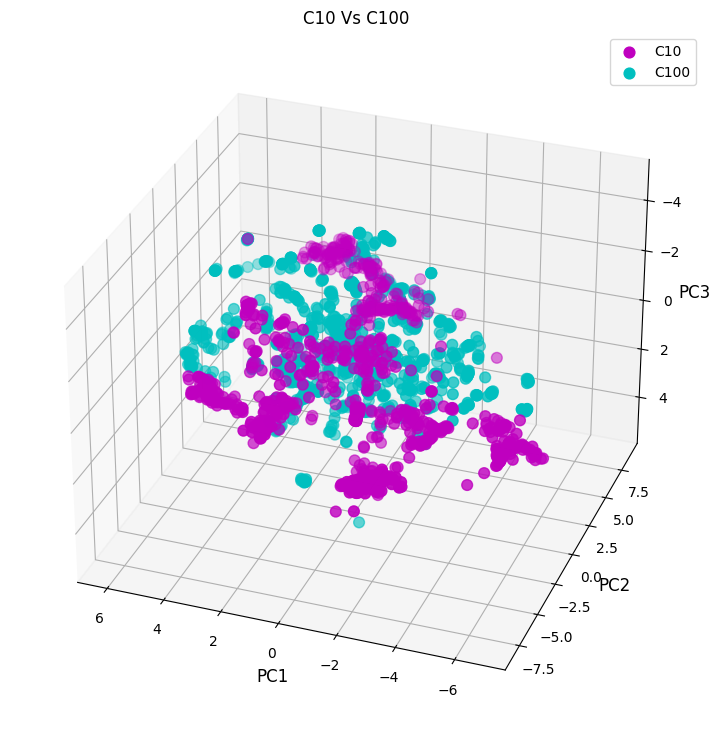

In [ ]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, projection='3d')

for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix],
            Yax[ix],
            Zax[ix],
            c=cdict[l],
            s=60,
           label=label[l])

ax.set_xlabel("PC1",
              fontsize=12)
ax.set_ylabel("PC2",
              fontsize=12)
ax.set_zlabel("PC3",
              fontsize=12)

ax.view_init(-150, 70)
ax.legend()
plt.title("C10 Vs C100")
plt.show()